# Determine if SNP changes RSS of nearby m6A motif GGACU

## Step 1: Obtain mutation ID, ref and alt on `dbSNP`
Obtain mutation position according to its chromosome and position on genotype, and get responding `snpID` on `dbSNP`.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
path = os.path.expanduser("~/Documents/m6A/")
exon_m6AQTL = f"{path}/Data/exon_m6AQTLs.txt"
output_exon_m6AQTL = f"{path}/Data/exon_m6AQTLs.bed"
intron_m6AQTL = f"{path}/Data/intron_m6AQTLs.txt"
output_intron_m6AQTL = f"{path}/Data/intron_m6AQTLs.bed"
output_dbSNP = f"{path}/Data/dbSNP/dbSNP.vcf.gz"
n = 200

Import dbSNP and export the first five columns, only need to do it once.

In [2]:
# input_dbSNP = f"{path}/Data/dbSNP/common_all_20170710.vcf.gz"
# dbSNP = pd.read_table(input_dbSNP, header = 56, compression = "gzip", usecols = [0,1,2,3,4], low_memory = False)
# dbSNP.to_csv(output_dbSNP, compression = "gzip", sep = "\t", index = False)

Handle exon and intron m6AQTL data
1. sort by chromosome and pos
2. plus and minus 200 for each pos

In [3]:
def load_m6AQTL(data_path):
    data = pd.read_table(data_path, header = 0)
    data = data.sort_values(by = ["chr", "pos"])
    data = data.set_index([[i for i in range(data.shape[0])]])
    data["strand"] = data.apply(lambda row: row["peakID"].split("_")[-1], axis = 1)
    data["gene_symbol"] = data.apply(lambda row: row["peakID"].split("_")[0], axis = 1)
    data["start"] = data.apply(lambda row: int(row["peakID"].split("_")[1]), axis = 1)
    data["end"] = data.apply(lambda row: int(row["peakID"].split("_")[2]), axis = 1)
    data["width"] = data.apply(lambda row: row["end"] - row["start"], axis = 1)
    data["pos1"] = data.apply(lambda row: row["pos"] - n, axis = 1)
    data["pos2"] = data.apply(lambda row: row["pos"] + n, axis = 1)
    data["gap"] = data.apply(lambda row: row["start"] - row["pos"], axis = 1)
    data["in"] = data.apply(lambda row: 1 if row["pos"] >= row["start"] and row["pos"] <= row["end"] else 0,axis=1)
    return data

In [4]:
intron_m6AQTL = load_m6AQTL(intron_m6AQTL)
exon_m6AQTL = load_m6AQTL(exon_m6AQTL)

In [5]:
print (intron_m6AQTL.shape, exon_m6AQTL.shape)

(12743, 18) (2997, 18)


In [6]:
intron_m6AQTL[["chr", "pos", "snpID", "start", "end", "width", "pos1", "pos2", "gene_symbol", "gap", "strand"]].head(5)

,chr,pos,snpID,start,end,width,pos1,pos2,gene_symbol,gap,strand
0,chr1,899937,rs143296006,981788,981988,200,899737,900137,AGRN,81851,+
1,chr1,899938,rs147467971,981788,981988,200,899738,900138,AGRN,81850,+
2,chr1,899942,rs71509448,981788,981988,200,899742,900142,AGRN,81846,+
3,chr1,943468,rs3121567,949466,949516,50,943268,943668,ISG15,5998,+
4,chr1,945612,rs3121565,949466,949516,50,945412,945812,ISG15,3854,+


In [7]:
exon_m6AQTL[["chr", "pos", "snpID", "start", "end", "width", "pos1", "pos2", "gene_symbol", "gap", "strand"]].head(5)

,chr,pos,snpID,start,end,width,pos1,pos2,gene_symbol,gap,strand
0,chr1,889403,rs62639963,879858,881654,1796,889203,889603,NOC2L,-9545,-
1,chr1,943468,rs3121567,949466,949516,50,943268,943668,ISG15,5998,+
2,chr1,947538,rs2465125,949466,949516,50,947338,947738,ISG15,1928,+
3,chr1,948421,rs113047134,949466,949516,50,948221,948621,ISG15,1045,+
4,chr1,948846,rs3841266,949466,949516,50,948646,949046,ISG15,620,+


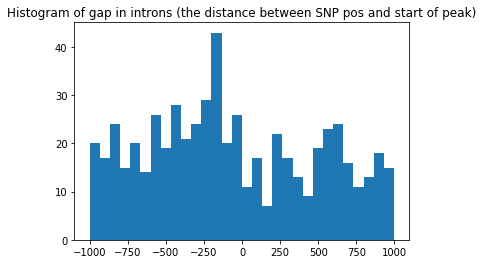

In [8]:
n1 = 1000
# gap = intron_m6AQTL["gap"].tolist()
intron_gap = intron_m6AQTL[(intron_m6AQTL["gap"] <= n1) & (intron_m6AQTL["gap"] >= -n1)]["gap"].tolist()
plt.hist(intron_gap, bins = 30)
plt.title("Histogram of gap in introns (the distance between SNP pos and start of peak)")
plt.show()

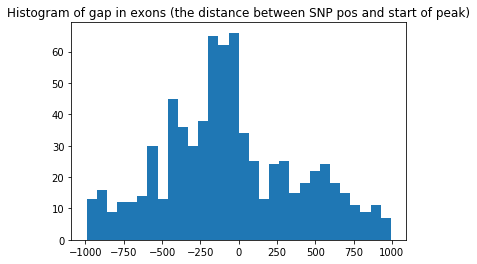

In [9]:
exon_gap = exon_m6AQTL[(exon_m6AQTL["gap"] <= n1) & (exon_m6AQTL["gap"] >= -n1)]["gap"].tolist()
plt.hist(exon_gap, bins = 30)
plt.title("Histogram of gap in exons (the distance between SNP pos and start of peak)")
plt.show()

In [10]:
dbSNP = pd.read_table(output_dbSNP, compression = "gzip", header = 0, sep = "\t", low_memory = False)
dbSNP.head(5)

,#CHROM,POS,ID,REF,ALT
0,1,10177,rs367896724,A,AC
1,1,10352,rs555500075,T,TA
2,1,10352,rs145072688,T,TA
3,1,10616,rs376342519,CCGCCGTTGCAAAGGCGCGCCG,C
4,1,10642,rs558604819,G,A


In [11]:
def get_m6AQTL(data, output_path):
    res = pd.merge(data, dbSNP, how = "inner", left_on = ["pos", "snpID"], right_on = ["POS", "ID"])
    res[["chr", "pos1", "pos2", "gene_symbol", "width", "strand"]].to_csv(output_path, 
                                                                   index = False, header = False, sep = "\t")
    cols = ["#CHROM", "POS", "ID", "REF", "ALT", "strand", "start", "end", "width", "gene_symbol", "pos1", "pos2", 
            "beta", "FDR"]
    return res[cols]

In [12]:
intron_m6AQTL = get_m6AQTL(intron_m6AQTL, output_intron_m6AQTL)
exon_m6AQTL = get_m6AQTL(exon_m6AQTL, output_exon_m6AQTL)

In [13]:
print (intron_m6AQTL.shape, exon_m6AQTL.shape)

(12537, 14) (2958, 14)


In [14]:
exon_m6AQTL.head(5)

,#CHROM,POS,ID,REF,ALT,strand,start,end,width,gene_symbol,pos1,pos2,beta,FDR
0,1,889403,rs62639963,T,A,-,879858,881654,1796,NOC2L,889203,889603,0.457022,0.053686
1,1,943468,rs3121567,T,C,+,949466,949516,50,ISG15,943268,943668,0.175897,0.081956
2,1,947538,rs2465125,C,T,+,949466,949516,50,ISG15,947338,947738,0.183229,0.045959
3,1,948421,rs113047134,A,AAAC,+,949466,949516,50,ISG15,948221,948621,0.236611,0.089250
4,1,948846,rs3841266,T,TA,+,949466,949516,50,ISG15,948646,949046,0.190571,0.013104


In [18]:
intron_m6AQTL.head(5)

,#CHROM,POS,ID,REF,ALT,strand,start,end,width,gene_symbol,pos1,pos2,beta,FDR
0,1,899937,rs143296006,G,T,+,981788,981988,200,AGRN,899737,900137,0.209051,0.099675
1,1,899938,rs147467971,G,"C,T",+,981788,981988,200,AGRN,899738,900138,0.209051,0.099675
2,1,899942,rs71509448,G,A,+,981788,981988,200,AGRN,899742,900142,0.256919,0.053348
3,1,943468,rs3121567,T,C,+,949466,949516,50,ISG15,943268,943668,0.175897,0.081956
4,1,945612,rs3121565,C,T,+,949466,949516,50,ISG15,945412,945812,0.193259,0.040843


### Use "bedtools" in bash under the depository
`~/Documents/m6A/Data/metApeakFisher`
```
bedtools intersect -a ../intron_m6AQTLs.bed -b peaks.merged.bed -s > peak.merged.intron.m6AQTL.bed
bedtools intersect -a ../exon_m6AQTLs.bed -b peaks.merged.bed -s > peak.merged.exon.m6AQTL.bed
```

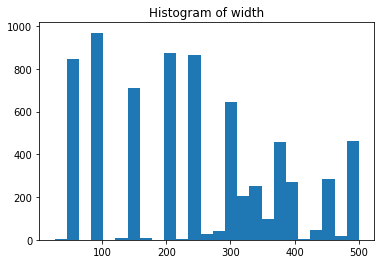

In [16]:
n2 = 500
width = intron_m6AQTL[intron_m6AQTL["width"] <= n2]["width"].tolist()
plt.hist(width, bins = 25)
plt.title("Histogram of width")
plt.show()

# Step 2: 

@NTCNCCACCC:K00180:212:H7VCTBBXX:3:1101:21673:1033 1:N:0:NAATTCGT+AGGCTNTA
@NCGNTCAAGA:K00180:212:H7VCTBBXX:3:1101:21755:1033 1:N:0:NAATTCGT+AGGCTNTA
@NCTNCCCGAG:K00180:212:H7VCTBBXX:3:1101:21795:1033 1:N:0:NAATTCGT+AGGCTNTA
@NTCNTCCAAC:K00180:212:H7VCTBBXX:3:1101:22465:1033 1:N:0:NAATTCGT+AGGCTNTA

@<instrument>:<run number>:<flowcell ID>:<lane>:<tile>:<x-pos>:<y-pos> <read>:<is filtered>:<control number>:<sample number>